In [1]:

import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms, utils


#dataset 
class CarDataset(Dataset):
    def __init__(self, guide_file, transform):
        with open(guide_file, 'r') as f_r:
            self.lines = f_r.readlines()
        self.transform = transform
    def __len__(self):
        return len(self.lines)
    def __getitem__(self, index):
        #print('invoke here')
        filename , model = self.lines[index].strip().split(' ')
        #print(filename)
        model = int(model)
        filename = '../Dataset' + filename[1:]
        #print(filename)
        image = Image.open(filename)
        #image = skimage.transform.rescale(io.imread(filename), (567, 800, 3)) #fix the image size, actually this causes trouble
        #print(image.shape)
        if self.transform :
            image = self.transform(image)
        #print(image.size())
        return {'image':image,'label': model}
            
transform = transforms.Compose([
    transforms.Resize(( 224,224)),
    transforms.ToTensor()
]
)          
            
dataset = CarDataset('../Dataset/full_make_name.txt', transform)

In [2]:
print(len(dataset))

136725


In [5]:
import random
test_indices = random.sample(range(0, len(dataset)), 2000)
train_indices = [x for x in list(range(0, len(dataset))) if x not in test_indices]
train_set = torch.utils.data.Subset(dataset, train_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size = 64, shuffle = True, drop_last = True, num_workers =4) 
test_loader = DataLoader(test_set, batch_size=64, shuffle = True, drop_last = True, num_workers =  4)


In [7]:
import torchvision
from torch import nn
model = torchvision.models.resnet34(pretrained=False, progress=True)
model.fc = nn.Linear(in_features = 512, out_features = 163)

In [8]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
optimizer = torch.optim.Adam(model.parameters())

In [12]:
criterion = nn.CrossEntropyLoss()
epoch_num = 10
for epoch in range(epoch_num):
    model.train()
    for index, batch in enumerate(train_loader):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        output = model(images)
        #print(output.size())
        #print(labels.size())
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        print("\r"+'Epoch: ' + str(epoch) +' Index: '+ str(index) + ' Train Loss: ' + str(loss.item()), end = '')
        
    loss_record = []
    with torch.no_grad():
        model.eval()
        for batch in test_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            output = model(images)
            output = model(images)
            loss = criterion(output, labels)
            loss_record.append(loss.item())
    loss = sum(loss_record)/len(loss_record)
    print('\n epoch: '+str(epoch)+', validation loss: '+str(loss))

Epoch: 0 Index: 2104 Train Loss: 4.0298871994018555
 epoch: 0, validation loss: 4.300271172677317
Epoch: 1 Index: 2104 Train Loss: 3.3778553009033203
 epoch: 1, validation loss: 3.5360128341182584
Epoch: 2 Index: 2104 Train Loss: 2.7301065921783447
 epoch: 2, validation loss: 2.719308284021193
Epoch: 3 Index: 2104 Train Loss: 2.2247731685638428
 epoch: 3, validation loss: 2.765967292170371
Epoch: 4 Index: 2104 Train Loss: 1.7202334403991705
 epoch: 4, validation loss: 1.930744997916683
Epoch: 5 Index: 2104 Train Loss: 1.3380174636840826
 epoch: 5, validation loss: 1.5283588132550638
Epoch: 6 Index: 2104 Train Loss: 0.51967471837997447
 epoch: 6, validation loss: 1.4435633017170815
Epoch: 7 Index: 2104 Train Loss: 0.46327996253967285
 epoch: 7, validation loss: 1.3682103753089905
Epoch: 8 Index: 2104 Train Loss: 0.23333746194839478
 epoch: 8, validation loss: 1.4577377957682456
Epoch: 9 Index: 2104 Train Loss: 0.20373709499835968
 epoch: 9, validation loss: 1.4434001599588702


In [14]:
##save the model, ignore if didn't run the training phase
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'checkpoint3/10_epoch.tar')

In [ ]:
# Epoch: 0 Index: 8419 Train Loss: 6.8445539474487305
#  epoch: 0, validation loss: 6.867287994384766
# Epoch: 1 Index: 8419 Train Loss: 6.8198108673095775
#  epoch: 1, validation loss: 6.645331008911133
# Epoch: 2 Index: 8419 Train Loss: 6.1215128898620605
#  epoch: 2, validation loss: 6.311001525878906
# Epoch: 3 Index: 8419 Train Loss: 5.4562177658081055
#  epoch: 3, validation loss: 5.8263019218444825

# Epoch: 0 Index: 8419 Train Loss: 4.5064420700073245
#  epoch: 0, validation loss: 5.375052528381348
# Epoch: 1 Index: 8419 Train Loss: 5.3554143905639655
#  epoch: 1, validation loss: 4.905608800888062
# Epoch: 2 Index: 8419 Train Loss: 3.4383392333984375
#  epoch: 2, validation loss: 4.473903726577759
# Epoch: 3 Index: 8419 Train Loss: 2.6703574657440186
#  epoch: 3, validation loss: 4.079521377563476
# Epoch: 4 Index: 8419 Train Loss: 3.1916491985321045
#  epoch: 4, validation loss: 3.7274326038360597
# Epoch: 5 Index: 8419 Train Loss: 2.1185774803161623
#  epoch: 5, validation loss: 3.5201592960357666

# Epoch: 0 Index: 8419 Train Loss: 1.55760908126831054
#  epoch: 0, validation loss: 3.3159831352233886
# Epoch: 1 Index: 8419 Train Loss: 0.47685241699218755
#  epoch: 1, validation loss: 3.2677871742248534
# Epoch: 2 Index: 8419 Train Loss: 0.87226676940917976
#  epoch: 2, validation loss: 3.1756063709259035
# Epoch: 3 Index: 8419 Train Loss: 0.895123481750488344
#  epoch: 3, validation loss: 3.25315739440918
# Epoch: 4 Index: 8419 Train Loss: 0.877222061157226635
#  epoch: 4, validation loss: 3.2391127243041993

# Epoch: 0 Index: 8419 Train Loss: 0.497129440307617264
#  epoch: 0, validation loss: 3.2249467334747313
# Epoch: 1 Index: 8419 Train Loss: 0.2563486099243164665
#  epoch: 1, validation loss: 3.359319543838501
# Epoch: 2 Index: 8419 Train Loss: 0.2095184326171875525
#  epoch: 2, validation loss: 3.398131549835205
# Epoch: 3 Index: 8419 Train Loss: 0.3847217559814453355
#  epoch: 3, validation loss: 3.4905024795532227
# Epoch: 4 Index: 8419 Train Loss: 0.0981330871582031255
#  epoch: 4, validation loss: 3.5211891975402834

In [13]:
import matplotlib.pyplot as plt
with open('../Dataset/full_make_name.txt', 'r') as f_r:
    lines = f_r.readlines()
filename, real_label = lines[6].strip().split(' ')
filename = '../Dataset' + filename[1:]
image = Image.open(filename)
transform = transforms.Compose([
transforms.Resize(( 224,224)),
transforms.ToTensor()])
plt.show(image)
transformed_image = transform(image).unsqueeze_(0)
print(transformed_image.size())
model.eval()
output = model(transformed_image.to(device))
_, predicted_label = output.max(1)
print(real_label)
print(predicted_label.item())

torch.Size([1, 3, 224, 224])
1
1


In [22]:
import scipy.io as skio
mapping_modelNum_string = skio.loadmat('../Dataset/data/misc/make_model_name.mat')['make_names'][:, 0]

with open('../Dataset/full_make_name.txt', 'r') as f_r:
    all_imagefiles = f_r.readlines()
print(len(all_imagefiles))


import matplotlib.pyplot as plt
def visualize_perf(k, model,transform, plot=False, print_result = True):
    model.eval()
    image_file, target = all_imagefiles[k].strip().split(' ')
    image_file = '../Dataset' + image_file[1:]
    image = Image.open(image_file)
    if(plot):
        plt.imshow(image)
        plt.show()
    image_tensor = transform(image).unsqueeze_(0).to(device)
    output = model(image_tensor)
    _, predicted_label = output.max(1)
    if(print_result):
        print('Predicted Model '+str(mapping_modelNum_string[predicted_label.item()-1]) + '\t' + 'Actual Model '+ str(mapping_modelNum_string[int(target)-1]))
    if(predicted_label == int(target)):
        return True
    else:
        return False
    

136725


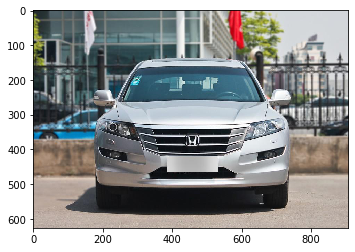

Predicted Model ['Honda']	Actual Model ['Honda']


True

In [23]:
visualize_perf(422, model, transform, plot=True, print_result=True)